### 1-Preparing the Data

##### About the Dataset:
###### InvoiceNo: Unique invoice number. Aborted operation if it starts with C.
###### StockCode: Unique product number.
###### Description: Product name.
###### Quantity: Number of products.
###### InvoiceDate: Invoice date and time.
###### UnitPrice: Product price.
###### CustomerID: Unique customer number.
###### Country: The country where the customer lives.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns",None)
pd.set_option("display.float_format",lambda x: "%.4f" %x)

In [2]:
data=pd.read_excel(r"online_retail_II.xlsx",sheet_name="Year 2009-2010")
df=data.copy()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom


#### As you can see there are negative values. There shouldn't be negative values. We'll drop them.
#### There are also outliers. There is too much difference between max-min and quartiles.

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,525461.0000,10.3377,107.4241,-9600.0000,1.0000,3.0000,10.0000,19152.0000
Price,525461.0000,4.6888,146.1269,-53594.3600,1.2500,2.1000,4.2100,25111.0900
Customer ID,417534.0000,15360.6455,1680.8113,12346.0000,13983.0000,15311.0000,16799.0000,18287.0000


### There are null values in Customer ID's variable. If we don't know the Customer ID then there is no means for analysing. We'll drop null-na values.

In [4]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df=df[~(df["Invoice"].str.contains("C",na=False))]

In [7]:
df=df[df["Quantity"] > 0]
df=df[df["Price"] > 0]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407664.0000,13.5856,96.8407,1.0000,2.0000,5.0000,12.0000,19152.0000
Price,407664.0000,3.2944,34.7580,0.0010,1.2500,1.9500,3.7500,10953.5000
Customer ID,407664.0000,15368.5926,1679.7621,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000


In [8]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [9]:
replace_with_thresholds(df, "Price")

In [10]:
replace_with_thresholds(df, "Quantity")

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407664.0000,11.9065,28.7251,1.0000,2.0000,5.0000,12.0000,358.5000
Price,407664.0000,3.0056,3.2506,0.0010,1.2500,1.9500,3.7500,36.9400
Customer ID,407664.0000,15368.5926,1679.7621,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000


##### Dropped Null, NAN and negative values. Outliers are compressed.

### 2-Data Structure Preparation
###### recency: Time since last purchase. Weekly. (user specific)
###### T: The age of the customer. Weekly. (how long before the analysis date the first purchase was made)
###### frequency: The total number of repeat purchases. (frequency > 1)
###### monetary_value: Average earnings per purchase

###### We need TotalPrice variable for CLTV prediction.

In [12]:
df["TotalPrice"]=df["Quantity"] * df["Price"]

In [13]:
#For calculating 'T'.
today_date=dt.datetime(2010,12,11)

In [14]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0000,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom,83.4000
1,489434,79323P,PINK CHERRY LIGHTS,12.0000,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom,81.0000
2,489434,79323W,WHITE CHERRY LIGHTS,12.0000,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom,81.0000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0000,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom,100.8000
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0000,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom,30.0000


In [15]:
cltv_df=df.groupby("Customer ID").agg({"InvoiceDate": [lambda x:(x.max() - x.min()).days,#Recency
                               lambda x:(today_date-x.min()).days],#T value
                               "Invoice": lambda x:x.nunique(),#frequency
                               "TotalPrice": lambda x:x.sum()})#monetary
cltv_df.columns=cltv_df.columns.droplevel(0)
cltv_df.columns=["recency","T","frequency","monetary"]
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,196,361,11,372.8600
12347.0000,37,40,2,1323.3200
12348.0000,0,74,1,222.1600
12349.0000,181,225,3,2295.0200
12351.0000,0,11,1,300.9300


### We have prepared our data structure. 

+ Now we have to change recency and T to weekly values.

+ Frequency value is greater than 1, so we should choose customers that we can consider as our customers.

+ We have to divide the Monetary value by the frequency value because it represents the average earnings per purchase.

In [16]:
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7
cltv_df=cltv_df[cltv_df["frequency"] > 1]
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,28.0000,51.5714,11,33.8964
12347.0000,5.2857,5.7143,2,661.6600
12349.0000,25.8571,32.1429,3,765.0067
12352.0000,2.2857,4.0000,2,171.9000
12356.0000,6.2857,8.5714,3,1187.4167


In [17]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2893.0000,28.5320,16.3933,0.0000,14.7143,29.8571,43.0000,53.2857
T,2893.0000,37.3931,14.7589,1.0000,28.0000,41.1429,51.4286,53.4286
frequency,2893.0000,6.1507,9.5274,2.0000,2.0000,4.0000,7.0000,205.0000
monetary,2893.0000,374.1855,340.0801,10.8222,199.7825,298.9629,436.9967,5633.4650


### 3-Creating BG/NBD Model

In [18]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [19]:
bgf = BetaGeoFitter().fit(cltv_df["frequency"],
                          cltv_df["recency"],
                          cltv_df["T"])
bgf

<lifetimes.BetaGeoFitter: fitted with 2893 subjects, a: 0.34, alpha: 11.16, b: 8.20, r: 2.20>

##### Let's make some inferences by BG/NBD Model

In [20]:
#Who are the 10 customers we expect the most to purchase in 1 week?
bgf.predict(1,
           cltv_df["frequency"],
           cltv_df["recency"],
           cltv_df["T"]).sort_values(ascending=False).head(11)

Customer ID
14911.0000   3.1916
17850.0000   2.3655
12748.0000   2.2630
15311.0000   1.8960
13089.0000   1.7039
14606.0000   1.6063
14156.0000   1.5778
13694.0000   1.4532
17841.0000   1.4364
18102.0000   1.4024
15061.0000   1.3533
dtype: float64

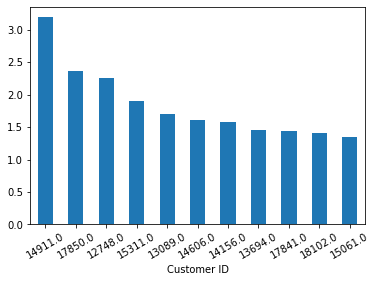

In [21]:
#Who are the 10 customers we expect the most to purchase in 1 week?
bgf.predict(1,
           cltv_df["frequency"],
           cltv_df["recency"],
           cltv_df["T"]).sort_values(ascending=False).head(11).plot(kind="bar")
plt.xticks(rotation=30)
plt.show()

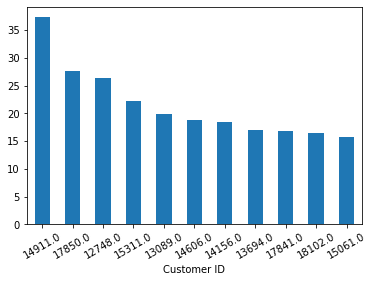

In [22]:
#Who are the 10 customers we expect the most to purchase in 3 months?
bgf.predict(12,
           cltv_df["frequency"],
           cltv_df["recency"],
           cltv_df["T"]).sort_values(ascending=False).head(11).plot(kind="bar")
plt.xticks(rotation=30)
plt.show()

In [23]:
cltv_df["expected_purc_for_1_week"]=bgf.predict(1,
           cltv_df["frequency"],
           cltv_df["recency"],
           cltv_df["T"])
cltv_df["expected_purc_for_3_months"]=bgf.predict(12,
           cltv_df["frequency"],
           cltv_df["recency"],
           cltv_df["T"])
cltv_df["expected_purc_for_6_months"]=bgf.predict(24,
           cltv_df["frequency"],
           cltv_df["recency"],
           cltv_df["T"])

In [24]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_for_1_week,expected_purc_for_3_months,expected_purc_for_6_months
Customer ID,,,,,,,
12346.0000,28.0000,51.5714,11,33.8964,0.0203,0.2393,0.4688
12347.0000,5.2857,5.7143,2,661.6600,0.2378,2.7209,5.2151
12349.0000,25.8571,32.1429,3,765.0067,0.1114,1.3085,2.5613
12352.0000,2.2857,4.0000,2,171.9000,0.2596,2.9563,5.6469
12356.0000,6.2857,8.5714,3,1187.4167,0.2467,2.8308,5.4365


In [25]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2893.0000,28.5320,16.3933,0.0000,14.7143,29.8571,43.0000,53.2857
T,2893.0000,37.3931,14.7589,1.0000,28.0000,41.1429,51.4286,53.4286
frequency,2893.0000,6.1507,9.5274,2.0000,2.0000,4.0000,7.0000,205.0000
monetary,2893.0000,374.1855,340.0801,10.8222,199.7825,298.9629,436.9967,5633.4650
expected_purc_for_1_week,2893.0000,0.1537,0.1542,0.0000,0.0830,0.1236,0.1877,3.1916
expected_purc_for_3_months,2893.0000,1.7957,1.7971,0.0000,0.9778,1.4520,2.1892,37.3068
expected_purc_for_6_months,2893.0000,3.5000,3.4945,0.0000,1.9232,2.8423,4.2688,72.7208


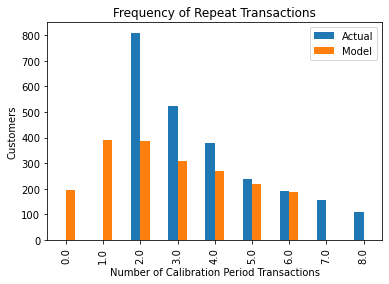

In [26]:
#Evaluation of Prediction Results
plot_period_transactions(bgf)
plt.show()

### 4-Creating Gamma-Gamma Model

In [27]:
ggf=GammaGammaFitter().fit(cltv_df["frequency"],cltv_df["monetary"])
ggf

<lifetimes.GammaGammaFitter: fitted with 2893 subjects, p: 1.66, q: 4.27, v: 745.06>

In [28]:
cltv_df["expected_average_profit"]=ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                                                           cltv_df["monetary"])
cltv_df.sort_values(by="expected_average_profit",ascending=False)

,recency,T,frequency,monetary,expected_purc_for_1_week,expected_purc_for_3_months,expected_purc_for_6_months,expected_average_profit
Customer ID,,,,,,,,
17450.0000,10.0000,10.5714,7,5321.5850,0.4086,4.6678,8.9319,4236.0454
18102.0000,53.2857,53.4286,89,3526.4424,1.4024,16.4050,31.9991,3458.2763
14646.0000,51.7143,53.2857,78,3108.7672,1.2066,14.1170,27.5392,3041.5123
12357.0000,0.0000,3.4286,2,5633.4650,0.2570,2.9221,5.5743,3025.9011
14088.0000,2.0000,8.1429,3,4512.9900,0.2157,2.4728,4.7458,2874.2104
...,...,...,...,...,...,...,...,...
17888.0000,49.0000,50.5714,17,64.3759,0.3034,3.5593,6.9616,96.9677
15359.0000,4.2857,47.0000,8,22.6687,0.0000,0.0001,0.0002,92.9224
12346.0000,28.0000,51.5714,11,33.8964,0.0203,0.2393,0.4688,86.1946


### Now it's time to predict the CLTV values, which is our main goal.

In [29]:
cltv=ggf.customer_lifetime_value(bgf,
                           cltv_df["frequency"],
                           cltv_df["recency"],
                           cltv_df["T"],
                           cltv_df["monetary"],
                           time=6, #for 6 Months
                           freq="W", #frequency information of T (W: Weekly)
                           discount_rate=0.01)
cltv.head()

Customer ID
12346.0000     42.2768
12347.0000   2834.7198
12349.0000   1638.9076
12352.0000   1615.1887
12356.0000   4916.6966
Name: clv, dtype: float64

### Yes, our variable has been created, but if you notice, its name is clv. We need to be careful when merging with the actual dataframe.

In [30]:
cltv=cltv.reset_index()
cltv_final=cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_for_1_week,expected_purc_for_3_months,expected_purc_for_6_months,expected_average_profit,clv
0,12346.0000,28.0000,51.5714,11,33.8964,0.0203,0.2393,0.4688,86.1946,42.2768
1,12347.0000,5.2857,5.7143,2,661.6600,0.2378,2.7209,5.2151,521.0389,2834.7198
2,12349.0000,25.8571,32.1429,3,765.0067,0.1114,1.3085,2.5613,611.7202,1638.9076
3,12352.0000,2.2857,4.0000,2,171.9000,0.2596,2.9563,5.6469,274.2912,1615.1887
4,12356.0000,6.2857,8.5714,3,1187.4167,0.2467,2.8308,5.4365,866.7103,4916.6966


### Now let's segment the clv values and move on to our analysis.

In [31]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

In [32]:
cltv_final.groupby("segment").agg(["sum","mean","count"])

Customer ID                     recency                        T  \
                  sum       mean count        sum    mean count        sum   
segment                                                                      
D       11218326.0000 15494.9254   724 16188.1429 22.3593   724 30964.2857   
C       11161568.0000 15437.8534   723 22393.7143 30.9733   723 27521.5714   
B       11024903.0000 15248.8285   723 21494.1429 29.7291   723 25092.7143   
A       11005204.0000 15221.5823   723 22467.1429 31.0749   723 24599.5714   

                      frequency                  monetary                 \
           mean count       sum    mean count         sum     mean count   
segment                                                                    
D       42.7684   724      2340  3.2320   724 169741.8598 234.4501   724   
C       38.0658   723      2962  4.0968   723 203758.7325 281.8240   723   
B       34.7064   723      3882  5.3693   723 270979.0812 374.7982   723   
A       34.0243   723      8610 11.9087   723 438039.0633 605.8632   723   

        expected_purc_for_1_week              expected_purc_for_3_months  \
                             sum   mean count                        sum   
segment                                                                    
D                        40.7099 0.0562   724                   479.6017   
C                        83.0493 0.1149   723                   975.0928   
B                       113.7613 0.1573   723                  1328.9681   
A                       207.2367 0.2866   723                  2411.3120   

                     expected_purc_for_6_months               \
          mean count                        sum   mean count   
segment                                                        
D       0.6624   724                   941.6951 1.3007   724   
C       1.3487   723                  1908.7140 2.6400   723   
B       1.8381   723                  2590.4041 3.5829   723   
A       3.3351   723                  4684.6473 6.4795   723   

        expected_average_profit                         clv                  
                            sum     mean count          sum      mean count  
segment                                                                      
D                   212903.9465 294.0662   724  262472.6278  362.5313   724  
C                   225444.9265 311.8187   723  580478.8312  802.8753   723  
B                   267066.3883 369.3864   723  914605.6209 1265.0147   723  
A                   394489.3574 545.6284   723 2718793.8906 3760.4342   723

###### Recency: 

+ It seems that we did not catch what we expected in terms of recency values.
+ But in fact, as the first and last date of a purchase (customer specific) and the frequency of the customer increase, the monetary value that the customer will leave will increase as well. Therefore, as the segments increase, the recency value may also increase. The recency value here should not be compared with the recency value in the RFM analysis.

###### T (Age of the Customer): 

+ As the age of the customer decreases, the expected average profit and clv value increase.
+ The age of the customer can be inversely proportional to both frequency and monetary value. Here it is inversely proportional to both. In other words, while the T value decreased, the frequency and monetary value increased.

###### Frequency: 

+ As the frequency value increased, the clv value and the expected average profit value increased.
+ As can be seen, the frequency value of the A segment is more than twice that of the B segment.

###### Monetary: 

+ The monetary value directly affects the expected average profit value and the clv value.
+ Thinking logically, the ideal customer is the one who makes the most frequent purchases and leaves the most monetary value in the shortest periods of time.

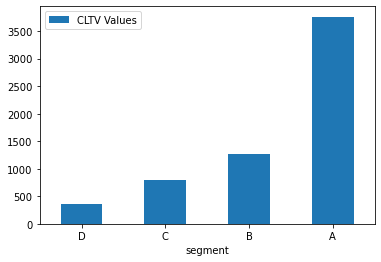

In [33]:
cltv_final.groupby("segment")["clv"].mean().plot(kind="bar"
                                                ,label="CLTV Values")
plt.legend()
plt.xticks(rotation=0)
plt.show()

In [34]:
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_for_1_week,expected_purc_for_3_months,expected_purc_for_6_months,expected_average_profit,clv,segment
0,12346.0000,28.0000,51.5714,11,33.8964,0.0203,0.2393,0.4688,86.1946,42.2768,D
1,12347.0000,5.2857,5.7143,2,661.6600,0.2378,2.7209,5.2151,521.0389,2834.7198,A
2,12349.0000,25.8571,32.1429,3,765.0067,0.1114,1.3085,2.5613,611.7202,1638.9076,A
3,12352.0000,2.2857,4.0000,2,171.9000,0.2596,2.9563,5.6469,274.2912,1615.1887,B
4,12356.0000,6.2857,8.5714,3,1187.4167,0.2467,2.8308,5.4365,866.7103,4916.6966,A


### Yes, we calculated our CLTV values and performed our analysis. Now, according to this analysis, we can take special steps for our customers or we can take segment-specific steps. In fact, since we find the sales figures, we reduce the burden on the sales and marketing team.

### Now it's time to functionalize the process.

In [35]:
def create_cltv (dataframe, csv=False, month = 3):
    # Preparing the Data
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~(dataframe["Invoice"].str.contains("C",na=False))]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    today_date = dt.datetime(2011, 12, 11)

    cltv_df = dataframe.groupby("Customer ID").agg(
        {"InvoiceDate": [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
         "Invoice": lambda Invoice: Invoice.nunique(),
         "TotalPrice": lambda TotalPrice: TotalPrice.sum()})

    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ["recency", "T", "frequency", "monetary"]
    cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
    cltv_df = cltv_df[(cltv_df["frequency"] > 1)]
    cltv_df["recency"] = cltv_df["recency"] / 7
    cltv_df["T"] = cltv_df["T"] / 7
     
    # 2. Creating BG/NBD Model
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])

    cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                                   cltv_df["frequency"],
                                                   cltv_df["recency"],
                                                   cltv_df["T"])

    cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                   cltv_df["frequency"],
                                                   cltv_df["recency"],
                                                   cltv_df["T"])

    cltv_df["expected_purc_3_month"] = bgf.predict(12,
                                                   cltv_df["frequency"],
                                                   cltv_df["recency"],
                                                   cltv_df["T"])

    # 3. Creating Gamma-Gamma Model
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df["frequency"], cltv_df["monetary"])
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                                 cltv_df['monetary'])

    # Calculating the CLTV
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df["frequency"],
                                       cltv_df["recency"],
                                       cltv_df["T"],
                                       cltv_df["monetary"],
                                       time=month,
                                       freq="W",
                                       discount_rate=0.01)

    cltv = cltv.reset_index()
    cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
    cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])
    
    if csv==True:
        cltv_final.to_csv("cltv_final")

    return cltv_final

# We have come to the end of the CLTV Prediction episode. Thank You Everyone 😇